<a href="https://colab.research.google.com/github/yellowleather/LLM-Fundamentals/blob/main/Build_Your_Adv_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to LangGraph**



Welcome! In this warm-up you’ll the key concepts of **LangGraph**.  

By the end you can:

| You will be able to… | Why it matters |
| --- | --- |
| Explain the parts of a `StateGraph` | All LangGraph projects share these building blocks |
| Write & connect multiple agents | Real-world apps chain specialised LLM tools |
| Inspect state as it flows | Debugging & observability are key |

---

### 📖 Table of Contents  
1. [Install dependencies](#install)  
2. [Define shared state](#state)  
3. [Create three agents](#agents)  
4. [Build the graph](#graph)  
5. [Run & inspect](#run)  
6. [Next steps](#next)


<a id="install"></a>
## Step 1  — Install Dependencies

We need **LangGraph** for orchestration and **LangChain** for helper classes.  
Run the cell below, then **restart the kernel** so the new packages load cleanly.


In [ ]:
!pip install -q --upgrade langgraph langchain  # ! not bare ‘pip’ for Jupyter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.0/473.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 11.4 MB/s eta 0:00:00


## Step 2  — Define the Shared State

The **state** is a single `TypedDict` that every agent can **read** and **update**  
— think of it as a strongly-typed, mutable “whiteboard”.

In [ ]:
from typing import TypedDict

class TravelState(TypedDict, total=False):
    user_input: str          # raw question
    destination: str         # “Bali”, “Manali”, …
    itinerary: str           # multi-day plan
    activities: str          # granular activities

## Step 3  — Create Three Simple Nodes

| Agent | Responsibility |
| --- | --- |
| `destination_node` | Choose a place that matches the user’s intent |
| `itinerary_node` | Draft a rough, three-day itinerary |
| `activity_node` | Suggest activities fitting that place |

Each agent is an ordinary Python function that takes `TravelState` ➜ returns an **updated** `TravelState`.


In [ ]:
def destination_agent(state: TravelState) -> TravelState:
    """ LangGraph node for destination agent """
    print("🔧 destination_agent running…")
    q = state.get("user_input", "").lower()

    if "beach" in q:
        dest = "Bali"
    elif "snow" in q or "mountain" in q:
        dest = "Manali"
    else:
        dest = "Kyoto"  # sensible default

    print(f"🌍 Suggested destination: {dest}")
    return {**state, "destination": dest}

In [ ]:
def itinerary_agent(state: TravelState) -> TravelState:
    """ LangGraph node for itinerary agent """
    print("🔧 itinerary_agent running…")
    dest = state["destination"]
    plan = (
        f"Day 1: Arrive in {dest}\n"
        f"Day 2: Explore iconic spots in {dest}\n"
        f"Day 3: Relax + sample local cuisine"
    )
    print(f"🧳 Draft itinerary:\n{plan}")
    return {**state, "itinerary": plan}

In [ ]:
def activity_agent(state: TravelState) -> TravelState:
    """ LangGraph node for activity agent """
    print("🔧 activity_agent running…")
    dest = state["destination"]
    act = (
        "Snorkelling • Beach yoga"
        if dest == "Bali"
        else "Skiing • Mountain trek"
    )
    print(f"🎯 Suggested activities: {act}")
    return {**state, "activities": act}

## Step 4  — Build the LangGraph Workflow

A `StateGraph` wires **nodes** (our agents) with **edges** (execution order).  
Below we:

1. add each agent as a node  
2. set the entry & finish points  
3. connect the nodes in series  
4. compile to an executable graph


In [ ]:
from langgraph.graph import StateGraph

builder = StateGraph(TravelState)

builder.add_node("destination_agent", destination_agent)
builder.add_node("itinerary_agent", itinerary_agent)
builder.add_node("activity_agent", activity_agent)

builder.set_entry_point("destination_agent")
builder.add_edge("destination_agent", "itinerary_agent")
builder.add_edge("itinerary_agent", "activity_agent")
builder.set_finish_point("activity_agent")

travel_graph = builder.compile()
print("✅ Graph compiled.")

✅ Graph compiled.


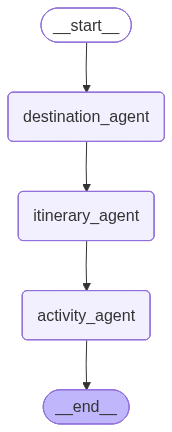

In [ ]:
from IPython.display import Image, display

display(Image(travel_graph.get_graph().draw_mermaid_png()))

## Step 5  — Run & Inspect

Let’s invoke the graph with a sample query and watch the logged output.

In [ ]:
initial_state: TravelState = {
    "user_input": "I want a relaxing beach vacation"
}

final_state = travel_graph.invoke(initial_state)

print("\n🏁 Final state:")
for k, v in final_state.items():
    print(f"{k}: {v}")

🔧 destination_agent running…
🌍 Suggested destination: Bali
🔧 itinerary_agent running…
🧳 Draft itinerary:
Day 1: Arrive in Bali
Day 2: Explore iconic spots in Bali
Day 3: Relax + sample local cuisine
🔧 activity_agent running…
🎯 Suggested activities: Snorkelling • Beach yoga

🏁 Final state:
user_input: I want a relaxing beach vacation
destination: Bali
itinerary: Day 1: Arrive in Bali
Day 2: Explore iconic spots in Bali
Day 3: Relax + sample local cuisine
activities: Snorkelling • Beach yoga


## 🔬 Understanding State Transitions

Below is a condensed view of how the state mutated:

| After node | `destination` | `itinerary` | `activities` |
| --- | --- | --- | --- |
| **initial** | — | — | — |
| `destination_agent` | ✅ | — | — |
| `itinerary_agent` | ✅ | ✅ | — |
| `activity_agent` | ✅ | ✅ | ✅ |

Each agent **adds** to (or updates) the same `TravelState` object — no hidden globals.


## ✏️ Your Turn  — Get Your Hands Dirty

1. **Snow scenario** — Change the input to “I want a snowy mountain retreat” and re-run.  
   *What destination, itinerary, and activities do you get?*

2. **Branching logic** — Extend `destination_agent` to detect “city break” and route to **Paris**, then tweak `itinerary_agent` accordingly.

*(Feel free to add extra cells beneath this one.)*


In [ ]:
initial_state: TravelState = {
    "user_input": "I want a snowy mountain retreat"
}

final_state = travel_graph.invoke(initial_state)

print("\n🏁 Final state:")
for k, v in final_state.items():
    print(f"{k}: {v}")

🔧 destination_agent running…
🌍 Suggested destination: Manali
🔧 itinerary_agent running…
🧳 Draft itinerary:
Day 1: Arrive in Manali
Day 2: Explore iconic spots in Manali
Day 3: Relax + sample local cuisine
🔧 activity_agent running…
🎯 Suggested activities: Skiing • Mountain trek

🏁 Final state:
user_input: I want a snowy mountain retreat
destination: Manali
itinerary: Day 1: Arrive in Manali
Day 2: Explore iconic spots in Manali
Day 3: Relax + sample local cuisine
activities: Skiing • Mountain trek


In [ ]:
def new_destination_agent(state: TravelState) -> TravelState:
    print("🔧 new_destination_agent running…")
    q = state.get("user_input", "").lower()

    if "beach" in q:
        dest = "Bali"
    elif "snow" in q or "mountain" in q:
        dest = "Manali"
    elif "city break" in q or "city" in q:
        dest = "Paris"
    else:
        dest = "Kyoto"  # sensible default

    print(f"🌍 Suggested destination: {dest}")
    return {**state, "destination": dest}

def new_itinerary_agent(state: TravelState) -> TravelState:
    print("🔧 new_itinerary_agent running…")
    dest = state["destination"]
    if dest == "Paris":
        plan = (
            f"Day 1: Arrive in Paris, visit Eiffel Tower\n"
            f"Day 2: Explore Louvre Museum and Notre Dame\n"
            f"Day 3: Visit Montmartre and Sacré-Cœur Basilica"
        )
    else:
        plan = (
            f"Day 1: Arrive in {dest}\n"
            f"Day 2: Explore iconic spots in {dest}\n"
            f"Day 3: Relax + sample local cuisine"
        )
    print(f"🧳 Draft itinerary:\n{plan}")
    return {**state, "itinerary": plan}

In [ ]:
builder2 = StateGraph(TravelState)

builder2.add_node("destination_agent", new_destination_agent)
builder2.add_node("itinerary_agent", new_itinerary_agent)
builder2.add_node("activity_agent", activity_agent)

builder2.set_entry_point("destination_agent")
builder2.add_edge("destination_agent", "itinerary_agent")
builder2.add_edge("itinerary_agent", "activity_agent")
builder2.set_finish_point("activity_agent")

travel_graph2 = builder2.compile()
print("✅ Graph compiled.")

✅ Graph compiled.


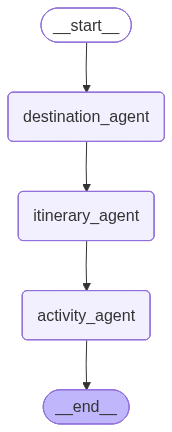

In [ ]:
from IPython.display import Image, display

display(Image(travel_graph2.get_graph().draw_mermaid_png()))

In [ ]:
initial_state: TravelState = {
    "user_input": "I want a city break retreat"
}

final_state = travel_graph2.invoke(initial_state)

print("\n🏁 Final state:")
for k, v in final_state.items():
    print(f"{k}: {v}")

🔧 new_destination_agent running…
🌍 Suggested destination: Paris
🔧 new_itinerary_agent running…
🧳 Draft itinerary:
Day 1: Arrive in Paris, visit Eiffel Tower
Day 2: Explore Louvre Museum and Notre Dame
Day 3: Visit Montmartre and Sacré-Cœur Basilica
🔧 activity_agent running…
🎯 Suggested activities: Skiing • Mountain trek

🏁 Final state:
user_input: I want a city break retreat
destination: Paris
itinerary: Day 1: Arrive in Paris, visit Eiffel Tower
Day 2: Explore Louvre Museum and Notre Dame
Day 3: Visit Montmartre and Sacré-Cœur Basilica
activities: Skiing • Mountain trek


# **Build a Multi-Agent System**





## Our Learning Path


| Step | Focus Area             | Description                                     |
|------|------------------------|-------------------------------------------------|
| 1️⃣   | Simple Agent           | Start by creating a basic LLM-powered agent     |
| 2️⃣   |  Multi-Agent System   |  Combine multiple agents using LangGraph    |
| 3️⃣   |  + Short-Term Memory   | Enhance the agent with session-level memory       |





## Step 1 — Setup & Imports


Before we dive into building agents, let's set up our development environment. We'll be using:

- **GPT 5**: Our powerful LLM for natural language understanding
- **LangGraph**: Framework for building stateful, multi-agent workflows
- **LangChain**: Tools for LLM application development

### Why These Tools?

- **GPT 5**: Fast, cost-effective, and excellent for conversational AI
- **LangGraph**: Perfect for complex workflows with multiple agents
- **Environment Variables**: Secure way to handle API keys


In [ ]:
!pip install -q --upgrade openai langchain-openai python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install -q langchain

#### **Set Up Your API Key**



In [ ]:
import os
from dotenv import load_dotenv
from google.colab import userdata

In [ ]:
# Load API key
load_dotenv()
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

In [ ]:
# Import everything we need
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END

## Step 2 — Core LLM Chain

We’ll now set up the core LLM using the `ChatGoogleGenerativeAI` class from LangChain (or your preferred wrapper). This model will power our generative AI tasks.




In [ ]:
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.2
)

## Step 3 - Create Individual Agents

### Itinerary Agent

Helps in planning the full travel itinerary and provides travel-related answers

In [ ]:
# Install required libraries for Tavily
!pip install -q tavily-python langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
# Import necessary modules
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from typing import TypedDict, Annotated, List, Union
import json

###### Set Up Tavily API Key

Tavily provides real-time web search capabilities for LLMs. To use it, you'll need an API key.

---

##### Get Your Tavily API Key

1. Visit the Tavily dashboard:  
   👉 [https://app.tavily.com/home](https://app.tavily.com/home)
2. Sign in or create an account.
3. Go to the **API Keys** section.
4. Copy your API key.

---

##### Enter Your API Key Securely in Colab

In [ ]:
# Step 1: Set up Tavily client and API key
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
#tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [ ]:
# Install or upgrade the LangChain-Tavily integration package silently
!pip install -q -U langchain-tavily

###### Use TavilySearch Tool from LangChain

Now that we’ve set up the Tavily API key, we can use the `TavilySearch` tool to perform real-time web searches within LangChain.

In [ ]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]

In [ ]:
# Test TavilySearch
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://dev.to/raunaklallala/understanding-core-concepts-of-langgraph-deep-dive-1d7h',
   'title': 'Understanding Core Concepts of LangGraph (Deep Dive)',
   'content': 'At the core, LangGraph has three simple but powerful building blocks: **Nodes, Edges, and State**. Each of those is a *Node*. In LangGraph, a Node can be many things: **Analogy:** If Nodes are stations, Edges are the railway tracks. * Shared state → memory that’s accessible to *all* nodes during execution. * **Node 1:** Input Capture → User enters “Hello World.” * Edges: If skills gap detected → route to skill-gap explainer node. Once you start thinking in terms of Nodes, Edges, and State, you realize this is less about AI “chats” and more about *AI workflows*. This trio (Nodes, Edges, State) is why LangGraph isn’t just a library, but a framework for *persistent, adaptive, multi-step systems* y

In [ ]:
# itinerary agent prompt to include ReAct reasoning
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an expert travel itinerary planner. ONLY respond to travel planning and itinerary-related questions.

IMPORTANT RULES:
- If asked about non-travel topics (weather, math, general questions), politely decline and redirect to travel planning
- Always provide complete, well-formatted itineraries with specific details
- Include timing, locations, transportation, and practical tips

Use the ReAct approach:
1. THOUGHT: Analyze what travel information is needed
2. ACTION: Search for current information about destinations, attractions, prices, hours
3. OBSERVATION: Process the search results
4. Provide a comprehensive, formatted response

Available tools:
- TavilySearch: Search for current travel information

Format your itineraries with:
- Clear day-by-day breakdown
- Specific times and locations
- Transportation between locations
- Estimated costs when possible
- Practical tips and recommendations"""),
    MessagesPlaceholder(variable_name="messages"),
])

In [ ]:
itinerary_prompt

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [ ]:
# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# Create itinerary agent
itinerary_agent = itinerary_prompt | llm_with_tools

### Flight Search Agent

Searches for hotels based on user queries (location, date, budget)

In [ ]:
# Install required packages for flight agent
!pip install -q serpapi

###### Set Up SERP API Key (Google Search API)

SERP API allows you to access Google Search results in real time — useful for web search, SEO tools, and AI assistants.

---

##### Get Your SERP API Key

1. Visit the SERP API dashboard:  
   👉 [https://serpapi.com/dashboard](https://serpapi.com/dashboard)
2. Sign up or log in.
3. Copy your **private API key** from the dashboard.

---

##### Enter Your API Key Securely in Colab



In [ ]:
import serpapi

# Set up SERP API key
os.environ["SERPAPI_API_KEY"] = userdata.get("SERPAPI_API_KEY")

###### Build Flight Search Tool

In [ ]:
from langchain_core.tools import tool


# Build flight search tool
def search_flights(departure_airport: str, arrival_airport: str, outbound_date: str, return_date: str = None, adults: int = 1, children: int = 0) -> str:
    """
    Search for flights using Google Flights engine.

    Args:
        departure_airport: Departure airport code (e.g., 'NYC', 'LAX')
        arrival_airport: Arrival airport code (e.g., 'LON', 'NRT')
        outbound_date: Departure date (YYYY-MM-DD format)
        return_date: Return date (YYYY-MM-DD format, optional for one-way)
        adults: Number of adult passengers (default: 1)
        children: Number of child passengers (default: 0)
    """

    # Ensure proper integer types
    adults = int(float(adults)) if adults else 1
    children = int(float(children)) if children else 0

    params = {
        'api_key': os.environ.get('SERPAPI_API_KEY'),
        'engine': 'google_flights',
        'hl': 'en',
        'gl': 'us',
        'departure_id': departure_airport,
        'arrival_id': arrival_airport,
        'outbound_date': outbound_date,
        'currency': 'USD',
        'adults': adults,
        'children': children,
        'type': '2' if not return_date else '1'  # FIX #1: Added type parameter (2=one-way)
        # REMOVED: 'stops': '1'  # FIX #2: This parameter doesn't exist!
    }


    if return_date:
        params['return_date'] = return_date

    try:
        search = serpapi.search(params)
        results = search.data.get('best_flights', [])

        # Fallback to other_flights if no best_flights
        if not results:
            results = search.data.get('other_flights', [])

        return json.dumps(results, indent=2)
    except Exception as e:
        return f"Flight search failed: {str(e)}"

In [ ]:
# # Define the tool explicitly
# search_flights_tool = Tool.from_function(
#     func=search_flights,
#     name="search_flights",
#     description="Search for flights using Google Flights engine."
# )

###### Define Flight Agent

In [ ]:
# flight agent prompt
flight_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a flight booking expert. ONLY respond to flight-related queries.

IMPORTANT RULES:
- If asked about non-flight topics, politely decline and redirect to flight booking
- Always use the search_flights tool to find current flight information
- You CAN search for flights and analyze the results for:
  * Direct flights vs connecting flights
  * Different airlines and flight classes
  * Various price ranges and timing options
  * Flight duration and layover information
- When users ask for specific preferences (direct flights, specific class, etc.), search first then filter/analyze the results
- Present results clearly organized by outbound and return flights

Available tools:
- search_flights: Search for comprehensive flight data that includes all airlines, classes, and connection types

Process:
1. ALWAYS search for flights first using the tool
2. Analyze the results to find flights matching user preferences
3. Present organized results with clear recommendations

Airport code mapping:
- Delhi: DEL
- London Heathrow: LHR
- New York: JFK/LGA/EWR
- etc."""),
    MessagesPlaceholder(variable_name="messages"),
])


In [ ]:
# Bind tools and create flight agent
llm_with_flight_tools = llm.bind_tools([search_flights])

In [ ]:
# flight agent
flight_agent = flight_prompt | llm_with_flight_tools

### Hotel Agent

In [ ]:
# hotel search tool
def search_hotels(location: str, check_in_date: str, check_out_date: str, adults: int = 1, children: int = 0, rooms: int = 1, hotel_class: str = None, sort_by: int = 8) -> str:
    """
    Search for hotels using Google Hotels engine.

    Args:
        location: Location to search for hotels (e.g., 'New York', 'Paris', 'Tokyo')
        check_in_date: Check-in date (YYYY-MM-DD format)
        check_out_date: Check-out date (YYYY-MM-DD format)
        adults: Number of adults (default: 1)
        children: Number of children (default: 0)
        rooms: Number of rooms (default: 1)
        hotel_class: Hotel class filter (e.g., '2,3,4' for 2-4 star hotels)
        sort_by: Sort parameter (default: 8 for highest rating)
    """

    # Ensure proper integer types
    adults = int(float(adults)) if adults else 1
    children = int(float(children)) if children else 0
    rooms = int(float(rooms)) if rooms else 1
    sort_by = int(float(sort_by)) if sort_by else 8

    params = {
        'api_key': os.environ.get('SERPAPI_API_KEY'),
        'engine': 'google_hotels',
        'hl': 'en',
        'gl': 'us',
        'q': location,
        'check_in_date': check_in_date,
        'check_out_date': check_out_date,
        'currency': 'USD',
        'adults': adults,
        'children': children,
        'rooms': rooms,
        'sort_by': sort_by
    }

    # Only add hotel_class if provided
    if hotel_class:
        params['hotel_class'] = hotel_class

    try:
        search = serpapi.search(params)
        properties = search.data.get('properties', [])

        if not properties:
            return f"No hotels found. Available data keys: {list(search.data.keys())}"

        # Return top 5 results
        return json.dumps(properties[:5], indent=2)

    except Exception as e:
        return f"Hotel search failed: {str(e)}"

In [ ]:
# Hotel agent prompt
hotel_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a hotel booking expert. ONLY respond to hotel and accommodation-related queries.

IMPORTANT RULES:
- If asked about non-hotel topics, politely decline and redirect to hotel booking
- Always use the search_hotels tool to find current hotel information
- Provide detailed hotel options with prices, ratings, amenities, and location details
- Include practical booking advice and tips
- You CAN search and analyze results for different criteria like star ratings, price ranges, amenities

Available tools:
- search_hotels: Search for hotels using Google Hotels engine

When searching hotels, extract or ask for:
- Location/destination
- Check-in and check-out dates (YYYY-MM-DD format)
- Number of guests (adults, children)
- Number of rooms
- Hotel preferences (star rating, amenities, etc.)

Present results with:
- Hotel name and star rating
- Price per night and total cost
- Key amenities and features
- Location and nearby attractions
- Booking recommendations"""),
    MessagesPlaceholder(variable_name="messages"),
])

In [ ]:
# Bind tools and create hotel agent
llm_with_hotel_tools = llm.bind_tools([search_hotels])
hotel_agent = hotel_prompt | llm_with_hotel_tools

## Step 4 - Create Router


In [ ]:
from langchain_core.output_parsers import StrOutputParser

def create_router():
    """Creates a router for the three travel agents using LangGraph patterns"""

    router_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a routing expert for a travel planning system.

        Analyze the user's query and decide which specialist agent should handle it:

        - FLIGHT: Flight bookings, airlines, air travel, flight search, tickets, airports, departures, arrivals, airline prices
        - HOTEL: Hotels, accommodations, stays, rooms, hotel bookings, lodging, resorts, hotel search, hotel prices
        - ITINERARY: Travel itineraries, trip planning, destinations, activities, attractions, sightseeing, travel advice, weather, culture, food, general travel questions

        Respond with ONLY one word: FLIGHT, HOTEL, or ITINERARY

        Examples:
        "Book me a flight to Paris" → FLIGHT
        "Find hotels in Tokyo" → HOTEL
        "Plan my 5-day trip to Italy" → ITINERARY
        "Search flights from NYC to London" → FLIGHT
        "Where should I stay in Bali?" → HOTEL
        "What are the best attractions in Rome?" → ITINERARY
        "I need airline tickets" → FLIGHT
        "Show me hotel options" → HOTEL
        "Create an itinerary for Japan" → ITINERARY"""),

        ("user", "Query: {query}")
    ])

    router_chain = router_prompt | llm | StrOutputParser()
    def route_query(state):
        """Router function for LangGraph - decides which agent to call next"""

        # Get the latest user message
        user_message = state["messages"][-1].content

        print(f"🧭 Router analyzing: '{user_message[:50]}...'")

        try:
            # Get LLM routing decision
            decision = router_chain.invoke({"query": user_message}).strip().upper()
            print(f"🎯 Router decision: {decision}")

            # post process decision to make sure it's accurate
            if decision not in ["FLIGHT", "HOTEL", "ITINERARY"]:
                decision = "ITINERARY"

            # Map to our agent node names
            agent_mapping = {
                "FLIGHT": "flight_agent",
                "HOTEL": "hotel_agent",
                "ITINERARY": "itinerary_agent"
            }

            next_agent = agent_mapping.get(decision, "itinerary_agent")
            print(f"🎯 Router decision: {decision} → {next_agent}")

            return next_agent

        except Exception as e:
            print(f"⚠️ Router error, defaulting to itinerary_agent: {e}")
            return "itinerary_agent"

    return route_query

In [ ]:
# Create the router
router = create_router()
print("✅ Travel Router created for LangGraph!")

✅ Travel Router created for LangGraph!


## Step 5 - Define the State Schema

In [ ]:
from typing import TypedDict, Annotated, List, Optional
import operator
from langchain_core.messages import BaseMessage

class TravelPlannerState(TypedDict):
    """Simple state schema for travel multiagent system"""

    # Conversation history - persisted with checkpoint memory
    messages: Annotated[List[BaseMessage], operator.add]

    # Agent routing
    next_agent: Optional[str]

    # Current user query
    user_query: Optional[str]

## Step 6 - Create Agent Nodes

###### Itinerary Agent Node

In [ ]:
from langchain_core.messages import ToolMessage

# Agent node functions
def itinerary_agent_node(state: TravelPlannerState):
    """Itinerary planning agent node"""
    messages = state["messages"]
    response = itinerary_agent.invoke({"messages": messages})

    # Handle tool calls if present
    if hasattr(response, 'tool_calls') and response.tool_calls:
        tool_messages = []
        for tool_call in response.tool_calls:
            if tool_call['name'] == 'tavily_search_results_json':
                try:
                    tool_result = tool.search(query=tool_call['args']['query'], max_results=2)
                    tool_result = json.dumps(tool_result, indent=2)
                except Exception as e:
                    tool_result = f"Search failed: {str(e)}"

                tool_messages.append(ToolMessage(
                    content=tool_result,
                    tool_call_id=tool_call['id']
                ))

        if tool_messages:
            all_messages = messages + [response] + tool_messages
            final_response = itinerary_agent.invoke({"messages": all_messages})
            return {"messages": [response] + tool_messages + [final_response]}

    return {"messages": [response]}

###### Flight Agent Agent Node

In [ ]:
def flight_agent_node(state: TravelPlannerState):
    """Flight booking agent node"""
    messages = state["messages"]
    response = flight_agent.invoke({"messages": messages})

    if hasattr(response, 'tool_calls') and response.tool_calls:
        tool_messages = []
        for tool_call in response.tool_calls:
            if tool_call['name'] == 'search_flights':
                try:
                    tool_result = search_flights(**tool_call['args'])
                except Exception as e:
                    tool_result = f"Flight search failed: {str(e)}"

                tool_messages.append(ToolMessage(
                    content=tool_result,
                    tool_call_id=tool_call['id']
                ))

        if tool_messages:
            all_messages = messages + [response] + tool_messages
            final_response = flight_agent.invoke({"messages": all_messages})
            return {"messages": [response] + tool_messages + [final_response]}

    return {"messages": [response]}

###### Hotel Agent Node

In [ ]:
def hotel_agent_node(state: TravelPlannerState):
    """Hotel booking agent node"""
    messages = state["messages"]
    response = hotel_agent.invoke({"messages": messages})

    if hasattr(response, 'tool_calls') and response.tool_calls:
        tool_messages = []
        for tool_call in response.tool_calls:
            if tool_call['name'] == 'search_hotels':
                try:
                    tool_result = search_hotels(**tool_call['args'])
                except Exception as e:
                    tool_result = f"Hotel search failed: {str(e)}"

                tool_messages.append(ToolMessage(
                    content=tool_result,
                    tool_call_id=tool_call['id']
                ))

        if tool_messages:
            all_messages = messages + [response] + tool_messages
            final_response = hotel_agent.invoke({"messages": all_messages})
            return {"messages": [response] + tool_messages + [final_response]}

    return {"messages": [response]}

###### Router Node

In [ ]:
def router_node(state: TravelPlannerState):
    """Router node - determines which agent should handle the query"""
    user_message = state["messages"][-1].content
    next_agent = router(state)

    return {
        "next_agent": next_agent,
        "user_query": user_message
    }

## Step 7 - Conditonal Function

In [ ]:
# Conditional routing function

def route_to_agent(state: TravelPlannerState):
    """Conditional edge function - routes to appropriate agent based on router decision"""

    next_agent = state.get("next_agent")

    if next_agent == "flight_agent":
        return "flight_agent"
    elif next_agent == "hotel_agent":
        return "hotel_agent"
    elif next_agent == "itinerary_agent":
        return "itinerary_agent"
    else:
        # Default fallback
        return "itinerary_agent"

## Step 8 - Build Graph & Add Memory

In [ ]:
from langgraph.graph import StateGraph, END
from typing import Literal
from langgraph.checkpoint.memory import InMemorySaver

# Build the complete travel planning graph
workflow = StateGraph(TravelPlannerState)

# Add all nodes to the graph
workflow.add_node("router", router_node)
workflow.add_node("flight_agent", flight_agent_node)
workflow.add_node("hotel_agent", hotel_agent_node)
workflow.add_node("itinerary_agent", itinerary_agent_node)

In [ ]:
# Set entry point - always start with router
workflow.set_entry_point("router")

# Add conditional edge from router to appropriate agent
workflow.add_conditional_edges(
    "router",
    route_to_agent,
    {
        "flight_agent": "flight_agent",
        "hotel_agent": "hotel_agent",
        "itinerary_agent": "itinerary_agent"
    }
)

# Add edges from each agent back to END
workflow.add_edge("flight_agent", END)
workflow.add_edge("hotel_agent", END)
workflow.add_edge("itinerary_agent", END)

checkpointer = InMemorySaver()

# Compile the graph
travel_planner = workflow.compile(checkpointer=checkpointer)

print("✅ Travel Planning Graph built successfully!")

✅ Travel Planning Graph built successfully!


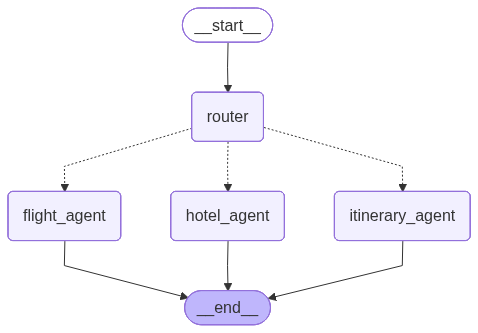

In [ ]:
from IPython.display import Image, display

# Generate and display the graph
graph_image = travel_planner.get_graph().draw_mermaid_png()
display(Image(graph_image))

## Step 9 - Test Your Multi-Agent System

In [ ]:
from langchain_core.messages import HumanMessage

def test_system(query, thread_id="test_thread"):
    """Test our multi-agent system"""
    print(f"🧑 User: {query}")

    # Create initial state
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "next_agent": ""
    }

    # Configuration for the checkpointer
    config = {"configurable": {"thread_id": thread_id}}

    # Run the system (use travel_planner)
    # We pass the config to invoke
    result = travel_planner.invoke(initial_state, config)

    # Get the response
    response = result["messages"][-1].content
    print(f"🤖 Assistant: {response}")
    print("-" * 50)

In [ ]:
# Test with different queries
test_system("I need to book a flight to Dubai on 30 Nov 2025 from New York for 1 person")

🧑 User: I need to book a flight to Dubai on 30 Nov 2025 from New York for 1 person
🧭 Router analyzing: 'I need to book a flight to Dubai on 30 Nov 2025 fr...'
🎯 Router decision: FLIGHT
🎯 Router decision: FLIGHT → flight_agent
🤖 Assistant: Here are some flight options from New York (JFK) to Dubai (DXB) on November 30, 2025, for one person:

### Option 1: Gulf Air (Connecting Flight)
- **Departure:** JFK at 11:55 AM
- **Arrival:** DXB at 12:10 PM (next day)
- **Layover:** Bahrain International Airport (BAH) for 1 hour 30 minutes
- **Total Duration:** 15 hours 15 minutes
- **Price:** $467
- **Flight Details:**
  - JFK to BAH: Boeing 787, Economy, Flight GF 90
  - BAH to DXB: Airbus A320, Economy, Flight GF 504
- **Features:** Above average legroom, Free Wi-Fi, In-seat power & USB outlets
- **Carbon Emissions:** 642 kg (15% lower than typical for this route)

### Option 2: Saudia (Connecting Flight)
- **Departure:** JFK at 11:00 AM
- **Arrival:** DXB at 1:00 PM (next day)
- **Layover:** Ki

In [ ]:
test_system("Find me a good hotel in New Delhi on 27 Nov 2025 for 1 night for 1 adult")

🧑 User: Find me a good hotel in New Delhi on 27 Nov 2025 for 1 night for 1 adult
🧭 Router analyzing: 'Find me a good hotel in New Delhi on 27 Nov 2025 f...'
🎯 Router decision: HOTEL
🎯 Router decision: HOTEL → hotel_agent


In [ ]:
test_system("What's the weather like in Paris?")

## Step 10 - Build an Interactive Chatbot

In [ ]:
from langchain_core.messages import HumanMessage

def multi_turn_chat():
    """Multi-turn conversation with checkpoint memory"""
    print("💬 Multi-Agent Travel Assistant (Multi-turn Mode)")
    print("=" * 50)

    # For multi-turn, you need a consistent thread/session ID
    config = {"configurable": {"thread_id": "1"}}

    while True:
        user_input = input("\n🧑 You: ")

        if user_input.lower() == 'quit':
            break

        print(f"\n📊 Processing query...")

        # For multi-turn, just add the new message
        # The graph will maintain conversation history automatically
        result = travel_planner.invoke(
            {"messages": [HumanMessage(content=user_input)]},
            config
        )

        response = result["messages"][-1].content
        print(f"\n🤖 Assistant: {response}")
        print("-" * 50)

In [ ]:
# Test multi-turn conversation
multi_turn_chat()

💬 Multi-Agent Travel Assistant (Multi-turn Mode)

🧑 You: find hotel for 1 person in delhi for 1 night from 27 nov 2025

📊 Processing query...
🧭 Router analyzing: 'find hotel for 1 person in delhi for 1 night from ...'
🎯 Router decision: HOTEL
🎯 Router decision: HOTEL → hotel_agent

🤖 Assistant: Here are some hotel options for your stay in Delhi on November 27, 2025, for one night:

1. **Hotel Gold Regency (3-star)**
   - **Price:** $59 per night
   - **Amenities:** Free breakfast, Free Wi-Fi, Parking, Air conditioning, Bar, Restaurant, Room service, Airport shuttle, Kid-friendly
   - **Location:** Near New Delhi Railway Station, 9 minutes by taxi to Jantar Mantar
   - **Rating:** 5/5 from 7752 reviews
   - **[More Details](https://thegoldregency.com/)**

2. **Hotel Season CoupleFriendly Hotel**
   - **Price:** $17 per night
   - **Amenities:** Free breakfast, Free Wi-Fi, Free parking, Air conditioning, Pet-friendly, Fitness center, Bar, Room service
   - **Location:** Near Pitampura Me